<a href="https://colab.research.google.com/github/javierj-f/final-project-CS506/blob/main/prelim_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import ephem
import numpy as np

# read tide data from 5 years

df_2019 = pd.read_csv("/tide_height_boston2019.csv")
df_2020 = pd.read_csv("/tide_height_boston2020.csv")
df_2021 = pd.read_csv("/tide_height_boston2021.csv")
df_2022 = pd.read_csv("/tide_height_boston2022.csv")
df_2023 = pd.read_csv("/tide_height_boston2023.csv")

# bring the datasets together

boston_df = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023])
boston_df["Datetime"] = pd.to_datetime(boston_df["Date"] + " " + boston_df["Time (GMT)"])

# format and drop unnecessary columns
boston_df = boston_df.set_index("Datetime")
boston_df = boston_df.drop(columns=["Date", "Time (GMT)", "Preliminary (ft)"])

# get the mean and maxes
daily_df = boston_df.resample("D").agg({
    "Predicted (ft)": "mean",
    "Verified (ft)": ["mean","max","min"]
})
daily_df.columns = ["Predicted_mean","Verified_mean","Verified_max","Verified_min"]

In [61]:
# dictate NOAA thresholds

minor_threshold = 12.5
moderate_threshold = 14.49
major_threshold = 16

# categorize the points by flood type

daily_df["Minor_Flood"] = daily_df["Verified_max"] > minor_threshold
daily_df["Moderate_Flood"] = daily_df["Verified_max"] > moderate_threshold
daily_df["Major_Flood"] = daily_df["Verified_max"] > major_threshold


In [62]:
# ephem helper methods

def get_moon_phase(date):
    if isinstance(date, pd.Timestamp):
        date = date.date()
    moon = ephem.Moon(date)
    return moon.phase

def categorize_phase(phase):
    if phase < 10 or phase > 90:
        return "New/Full Moon"
    elif 40 < phase < 60:
        return "Quarter Moon"
    else:
        return "Intermediate"

# attach lunar phase to timestamp

daily_df["Moon_Phase"] = [get_moon_phase(date) for date in daily_df.index]
daily_df["Phase_Category"] = daily_df["Moon_Phase"].apply(categorize_phase)

In [63]:
#!pip install meteostat

In [64]:
# TEST FOR NOW: IMPLEMENTING WEATHER DATA

from meteostat import Point, Daily
from datetime import datetime

boston = Point(42.3601, -71.0589)

weather_dfs = []
for year in range(2019, 2024):
    start = datetime(year, 1, 1)
    end = datetime(year, 12, 31)
    weather = Daily(boston, start, end).fetch()
    weather_dfs.append(weather)

weather_df = pd.concat(weather_dfs)
weather_df.index = pd.to_datetime(weather_df.index)

# Merge with daily tide data
merged_df = daily_df.merge(weather_df, left_index=True, right_index=True, how="inner")

# create "close to" class

buffer = 0.5
merged_df["Close_to_Flood"] = (
    (merged_df["Verified_max"] > (minor_threshold - buffer)) &
    (merged_df["Verified_max"] <= minor_threshold)
)



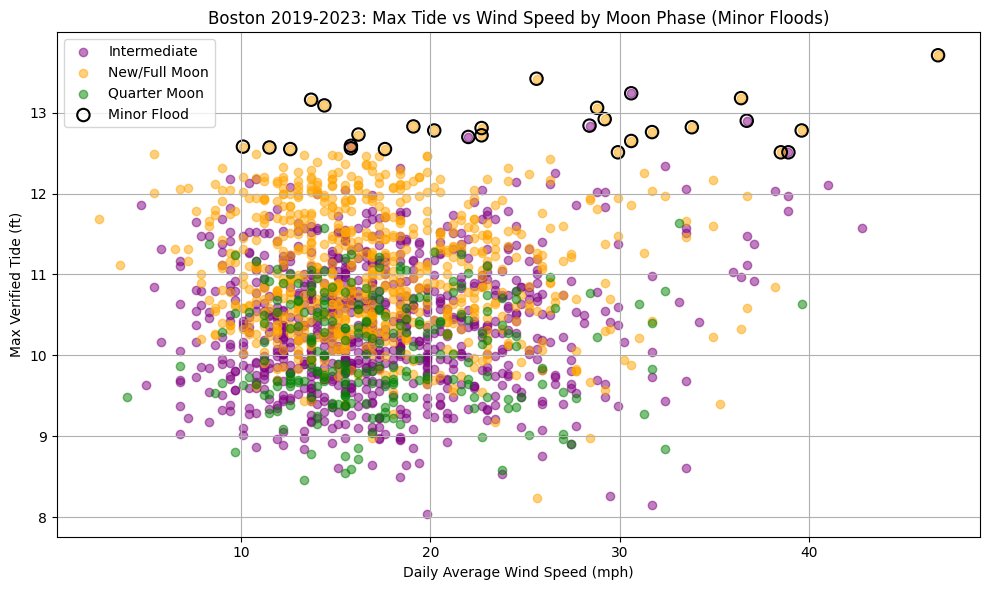

In [65]:
import matplotlib.pyplot as plt

colors = {"New/Full Moon":"orange", "Quarter Moon":"green", "Intermediate":"purple"}

plt.figure(figsize=(10,6))
for phase in merged_df["Phase_Category"].unique():
    subset = merged_df[merged_df["Phase_Category"] == phase]
    plt.scatter(
        subset["wspd"],
        subset["Verified_max"],
        color=colors[phase],
        alpha=0.5,
        label=phase
    )

# Highlight minor flood days
plt.scatter(
    merged_df[merged_df["Minor_Flood"]]["wspd"],
    merged_df[merged_df["Minor_Flood"]]["Verified_max"],
    facecolors='none', edgecolors='black', s=80, linewidths=1.5, label="Minor Flood"
)

plt.xlabel("Daily Average Wind Speed (mph)")
plt.ylabel("Max Verified Tide (ft)")
plt.title("Boston 2019-2023: Max Tide vs Wind Speed by Moon Phase (Minor Floods)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

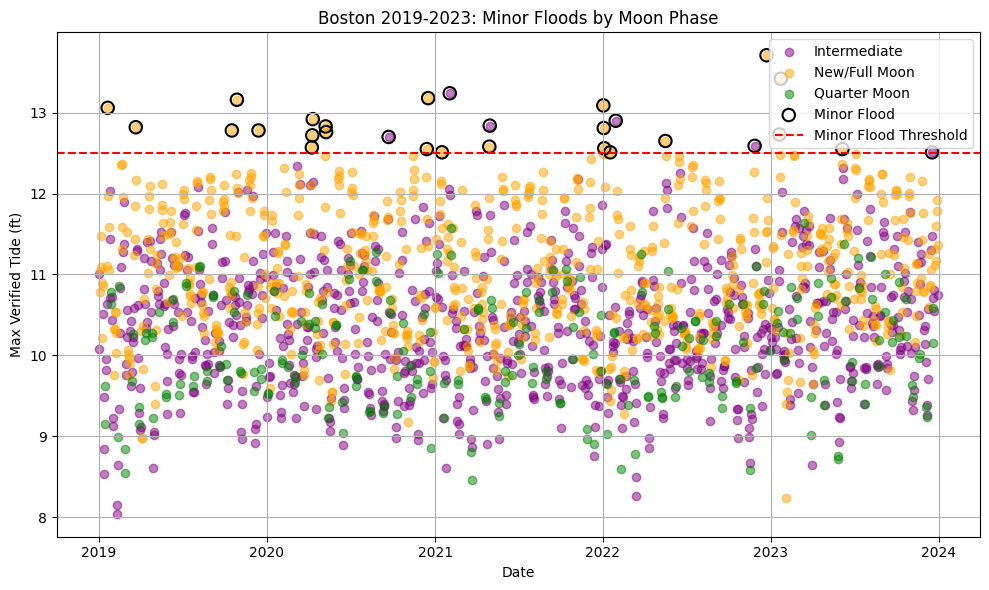

In [66]:
colors = {"New/Full Moon":"orange", "Quarter Moon":"green", "Intermediate":"purple"}

plt.figure(figsize=(10,6))

# Plot all days, colored by moon phase
for phase in merged_df["Phase_Category"].unique():
    subset = merged_df[merged_df["Phase_Category"] == phase]
    plt.scatter(
        subset.index,
        subset["Verified_max"],
        color=colors[phase],
        alpha=0.5,
        label=phase
    )

# Highlight minor flood days with black edge
plt.scatter(
    merged_df[merged_df["Minor_Flood"]].index,
    merged_df[merged_df["Minor_Flood"]]["Verified_max"],
    facecolors='none', edgecolors='black', s=80, linewidths=1.5, label="Minor Flood"
)

plt.axhline(y=minor_threshold, color='red', linestyle='--', label='Minor Flood Threshold')

plt.xlabel("Date")
plt.ylabel("Max Verified Tide (ft)")
plt.title("Boston 2019-2023: Minor Floods by Moon Phase")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

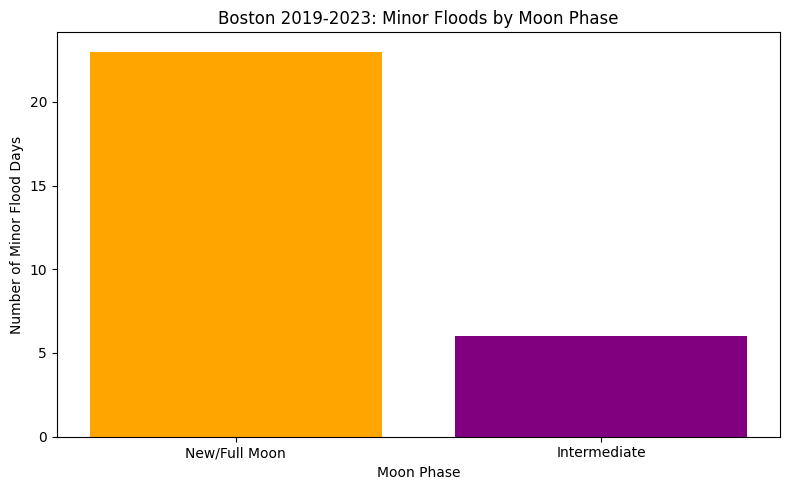

In [67]:
flood_counts = merged_df[merged_df["Minor_Flood"]].groupby("Phase_Category").size()

# Optional: order the phases consistently
phase_order = ["New/Full Moon", "Intermediate", "Quarter Moon"]
flood_counts = flood_counts.reindex(phase_order)

plt.figure(figsize=(8,5))
plt.bar(flood_counts.index, flood_counts.values, color=["orange", "purple", "green"])
plt.xlabel("Moon Phase")
plt.ylabel("Number of Minor Flood Days")
plt.title("Boston 2019-2023: Minor Floods by Moon Phase")
plt.tight_layout()
plt.show()

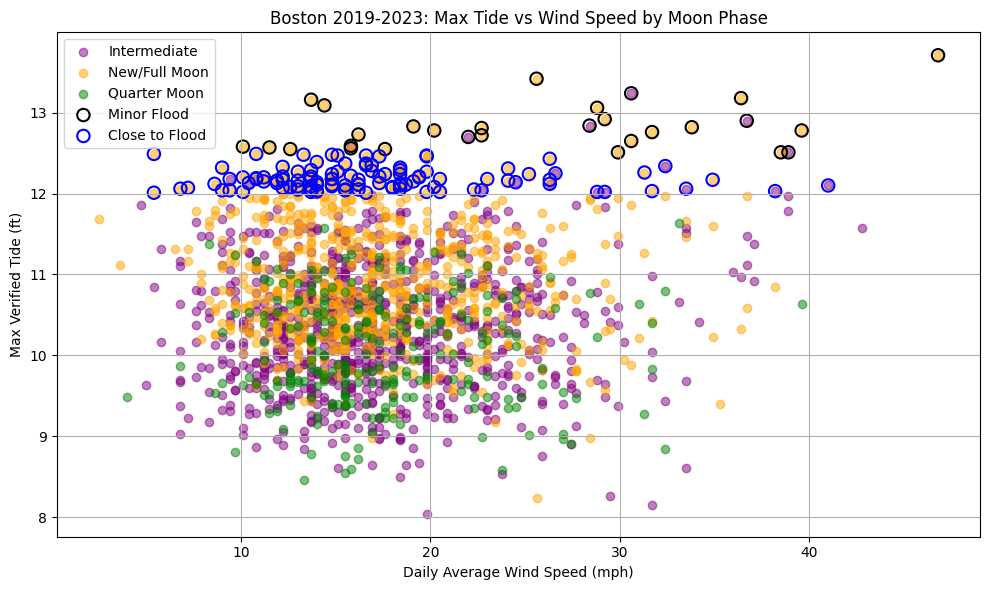

In [68]:
colors = {"New/Full Moon":"orange", "Quarter Moon":"green", "Intermediate":"purple"}

plt.figure(figsize=(10,6))

# Scatter plot by moon phase
for phase in merged_df["Phase_Category"].unique():
    subset = merged_df[merged_df["Phase_Category"] == phase]
    plt.scatter(
        subset["wspd"],
        subset["Verified_max"],
        color=colors[phase],
        alpha=0.5,
        label=phase
    )

# Highlight minor flood days
plt.scatter(
    merged_df[merged_df["Minor_Flood"]]["wspd"],
    merged_df[merged_df["Minor_Flood"]]["Verified_max"],
    facecolors='none', edgecolors='black', s=80, linewidths=1.5, label="Minor Flood"
)

# Highlight close to flood days with a different marker (e.g., yellow edge)
plt.scatter(
    merged_df[merged_df["Close_to_Flood"]]["wspd"],
    merged_df[merged_df["Close_to_Flood"]]["Verified_max"],
    facecolors='none', edgecolors='blue', s=80, linewidths=1.5, label="Close to Flood"
)

plt.xlabel("Daily Average Wind Speed (mph)")
plt.ylabel("Max Verified Tide (ft)")
plt.title("Boston 2019-2023: Max Tide vs Wind Speed by Moon Phase")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


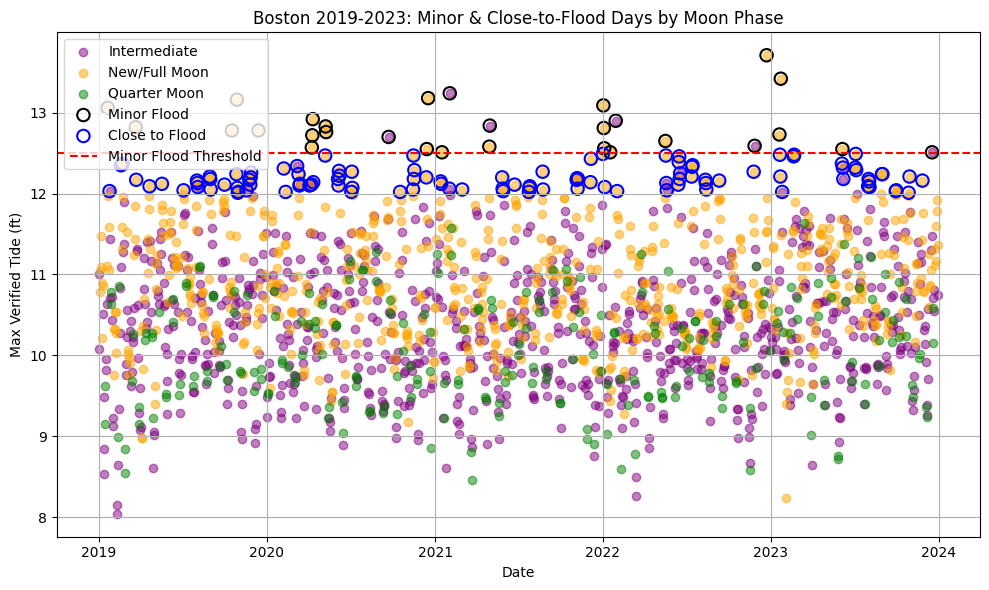

In [69]:
plt.figure(figsize=(10,6))

# Plot all days colored by moon phase
for phase in merged_df["Phase_Category"].unique():
    subset = merged_df[merged_df["Phase_Category"] == phase]
    plt.scatter(
        subset.index,
        subset["Verified_max"],
        color=colors[phase],
        alpha=0.5,
        label=phase
    )

# Minor floods (black edge)
plt.scatter(
    merged_df[merged_df["Minor_Flood"]].index,
    merged_df[merged_df["Minor_Flood"]]["Verified_max"],
    facecolors='none',
    edgecolors='black',
    s=80,
    linewidths=1.5,
    label="Minor Flood"
)

# Close to flood (yellow edge)
plt.scatter(
    merged_df[merged_df["Close_to_Flood"]].index,
    merged_df[merged_df["Close_to_Flood"]]["Verified_max"],
    facecolors='none',
    edgecolors='blue',
    s=80,
    linewidths=1.5,
    label="Close to Flood"
)

plt.axhline(y=minor_threshold, color='red', linestyle='--', label='Minor Flood Threshold')

plt.xlabel("Date")
plt.ylabel("Max Verified Tide (ft)")
plt.title("Boston 2019-2023: Minor & Close-to-Flood Days by Moon Phase")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

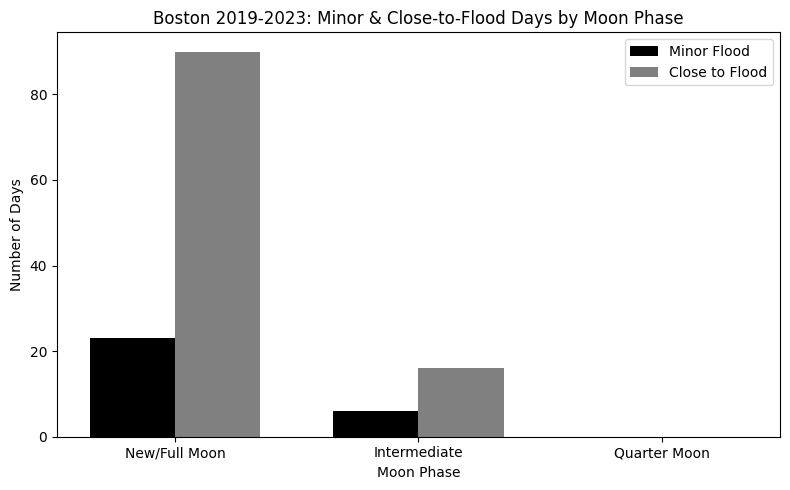

In [70]:
minor_counts = merged_df[merged_df["Minor_Flood"]].groupby("Phase_Category").size()
close_counts = merged_df[merged_df["Close_to_Flood"]].groupby("Phase_Category").size()

# Ensure consistent order
phase_order = ["New/Full Moon", "Intermediate", "Quarter Moon"]
minor_counts = minor_counts.reindex(phase_order, fill_value=0)
close_counts = close_counts.reindex(phase_order, fill_value=0)

# Create side-by-side bar chart
x = np.arange(len(phase_order))  # positions
width = 0.35  # bar width

plt.figure(figsize=(8,5))
plt.bar(x - width/2, minor_counts.values, width, label='Minor Flood', color='black')
plt.bar(x + width/2, close_counts.values, width, label='Close to Flood', color='grey')

plt.xticks(x, phase_order)
plt.xlabel("Moon Phase")
plt.ylabel("Number of Days")
plt.title("Boston 2019-2023: Minor & Close-to-Flood Days by Moon Phase")
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

features = ["Verified_max", "wspd", "tavg"]
X = merged_df[features].fillna(0)
y = merged_df["Minor_Flood"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00       361
        True       1.00      0.80      0.89         5

    accuracy                           1.00       366
   macro avg       1.00      0.90      0.94       366
weighted avg       1.00      1.00      1.00       366



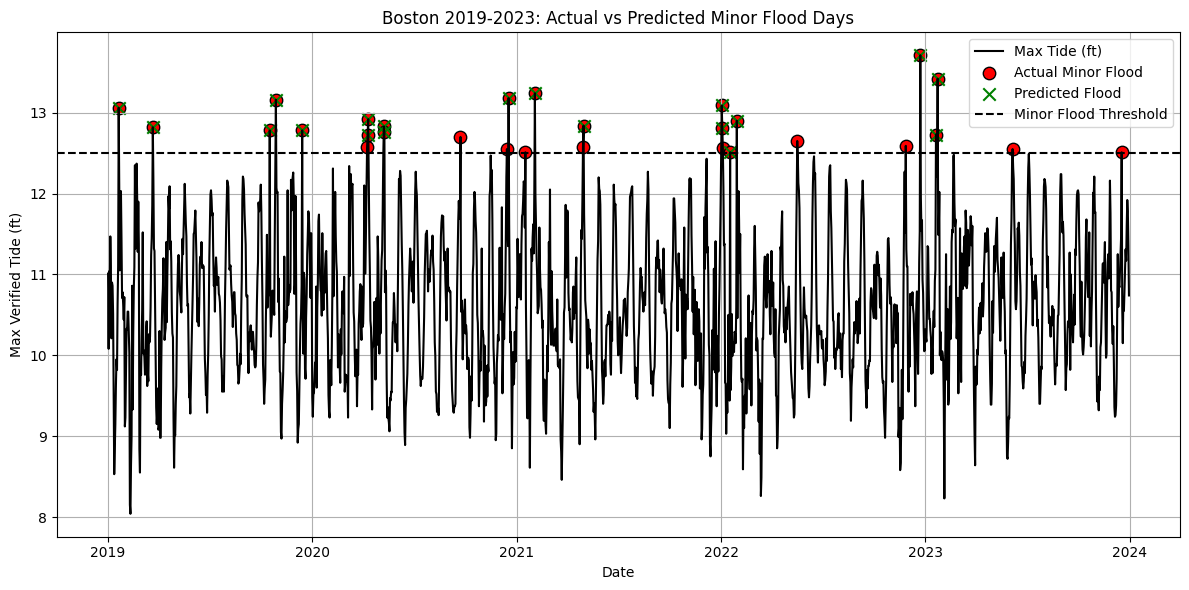

In [72]:
merged_df['Predicted_Flood'] = model.predict(X)

plt.figure(figsize=(12,6))

# Plot max tide
plt.plot(merged_df.index, merged_df["Verified_max"], label="Max Tide (ft)", color='black')

# Actual flood days
plt.scatter(
    merged_df[merged_df["Minor_Flood"]].index,
    merged_df[merged_df["Minor_Flood"]]["Verified_max"],
    color='red', s=80, marker='o', label='Actual Minor Flood', edgecolors='black'
)

# Predicted flood days
plt.scatter(
    merged_df[merged_df["Predicted_Flood"]].index,
    merged_df[merged_df["Predicted_Flood"]]["Verified_max"],
    color='green', s=80, marker='x', label='Predicted Flood'
)

# Minor flood threshold line
plt.axhline(y=minor_threshold, color='black', linestyle='--', label='Minor Flood Threshold')

plt.xlabel("Date")
plt.ylabel("Max Verified Tide (ft)")
plt.title("Boston 2019-2023: Actual vs Predicted Minor Flood Days")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()